In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [9]:
#Viral dynamics parameter
hour = 24
CL_V = 2.3/hour
lambdaT = 2e9/hour
deltaT = 0.02/hour
deltaT1 = 0.02/hour
deltaT2 = 1/hour
deltaPIC = 0.35/hour
k = 0.35/hour
beta = 8e-12/hour
CLT = beta
NThat = 1000/hour
NT = 670/hour  #NT = 0.67*NThat
NTdiff = 330/hour
Tu = lambdaT/deltaT
    
#PD parameters
IC50 = 458 #estimated
m = 1 #fixed

#Estimated PK parameter
ka = 45.4382
k10 =  0.2355
k12 =  0.175
k21 =  0.0259
Vc =  162.690 #mL

k13 = 44.2394
k30 = 0.00975

In [10]:
def eta(D,m):    
    res = D**m/(IC50**m + D**m)
    return res

def CL_T(D,m):
    return (1 + eta(D,m))*beta

def PE(X,D,m): #extinction probability for RTIs
    P_V0 = ((1-eta(D,m))*beta*Tu)/(((1-eta(D,m))*beta*Tu)+(CL_V + CL_T(D,m)*Tu))
    P_T1T2 = k/(deltaPIC+deltaT1+k)
    R0 = P_V0*P_T1T2*NT/deltaT2
    
    res_V = min(1,1-P_V0*P_T1T2*(1-1/R0))
    res_T1 = min(1,1-P_T1T2*(1-1/R0))
    res_T2 = min(1,1/R0)
    log_res = X[0]*np.log(res_V) + X[1]*np.log(res_T1) + X[2]*np.log(res_T2)
    return np.exp(log_res)

def phi(D,m):#prophylactic efficacy
    return 1 - (1-PE(Y0,D,m))/(1-PE(Y0,0,m))

#Compartment model
def ode(t, z):
    Z0 = z[0]; Z1 = z[1]; Z2 = z[2]; Z3 = z[3]
    dZ0 = -ka*Z0
    dZ1 = (ka/Vc)*Z0 - k10*Z1 - k12*Z1 + k21*Z2
    dZ2 = k12*Z1 - k21*Z2
    dZ3 = k13*Z1 - k30*Z3
    d = [dZ0,dZ1,dZ2,dZ3]
    return d

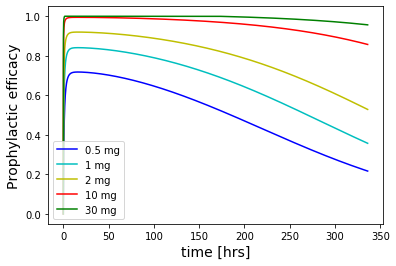

In [11]:
doses = [0.5,1,2,10,30]
Y0 = [1,0,0] #initial state of the system
c = ['b', 'c', 'y', 'r', 'g']

t0 = 0; tfinal = 336 #hours

j=0
for d in doses:
    # initial condition
    z0 = [d*3410, 0, 0, 0]
    
    t = np.linspace(t0, tfinal, 4000)
    res = solve_ivp(ode, (t0,tfinal), z0, t_eval=t)
    Z4List = list(res.y[3]) 
    tList = list(t) 
    
    phiList = []
    for i in range(len(Z4List)):
        phiList.append(phi(Z4List[i],m))
    
    #print('endpoint for '+str(d)+' mg '+str(phiList[-1:]))
    plt.plot(tList,phiList,c[j],label=str(d)+' mg')
    #plt.plot(tList, [0.85]*len(tList), 'k--')
    #plt.plot(tList, [0.95]*len(tList), 'k:')
    plt.ylabel('Prophylactic efficacy',fontsize=14)
    plt.xlabel('time [hrs]',fontsize=14)
    plt.legend(loc='lower left')
    #plt.title('Prophylactic efficacy after initial dose',fontsize=18)
    j+=1
    
plt.show()   